# Exploratory Data Analysis

## <font color='salmon'>Project: Quora Insincere Questions Classification Project</font> 

The following notebook will explore the data set provided in the quora kaggle competition. 

In [65]:
# Loading libraries
from sklearn import model_selection, metrics, linear_model, naive_bayes
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2, mutual_info_classif
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# Loading helper functions
import helper as h
pd.set_option('float_format', '{:f}'.format)

# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

## <font color='firebrick'>1. Basic Statistics </font> 
---

In [46]:
# Loading Data
tqdm.pandas()
train_set = pd.read_csv('Data/train.csv', encoding = 'latin1')
print('Sample of sincere questions')
train_set[train_set.target == 0].sample(3, random_state = 3)

Sample of sincere questions


,qid,question_text,target
609611,775fb805432cf184d6f9,What do you think of Jallikattu?,0
251920,314cfd7b0a403233d4c0,How can a civil engineer earn well in structur...,0
750481,930783154f445fac3fb9,How many licks would it take to dissolve a nic...,0


In [53]:
print('Sample of insincere questions')
train_set[train_set.target == 1].sample(3, random_state = 20)

Sample of insincere questions


,qid,question_text,target
736959,90548d5140d3a0b4d36e,Do most of the Chinese regularly eat cockroach...,1
307200,3c2badc823240a49f725,"Hitler, Pol Pot, and Mao Zedong forced away th...",1
949791,ba1c7c2b0d952944f44f,Do Indians hate Chinese?,1


In [3]:
print('The data has {} rows and {} columns'.format(train_set.shape[0], train_set.shape[1]))

The data has 1048575 rows and 3 columns


Strong class imbalance. There are 64774 of insincere question that representthe 6.2% of the data


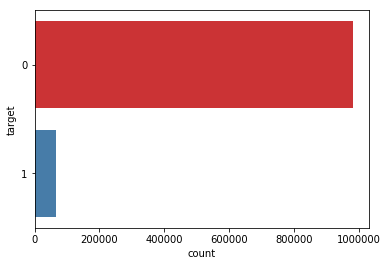

In [4]:
# Target variable count
ax = sns.countplot(y="target", data=train_set, palette="Set1") # strong class imbalance 
cnts = train_set.target.value_counts()
print("Strong class imbalance. " 
      "There are {} of insincere question that represent"
      "the {}% of the data".format(cnts[1], round(cnts[1]/sum(cnts)*100, 1)))

## <font color='firebrick'>2. Text Cleaning and preprocessing </font>
---

Applying lowercasing + punctuation removal + special character removal + stopwords removal and lemmatization. This process was donde in script `EDA_question.py`.

In [10]:
with open('Data/train_word_cloud.pkl', 'rb') as input:
    train_set = pickle.load(input)

## <font color='firebrick'>3. Basic Statistics </font>
---
### 3.1 Word level Statistics

Will analyze unigram and bigram wordclouds.

Sincere Unigrams


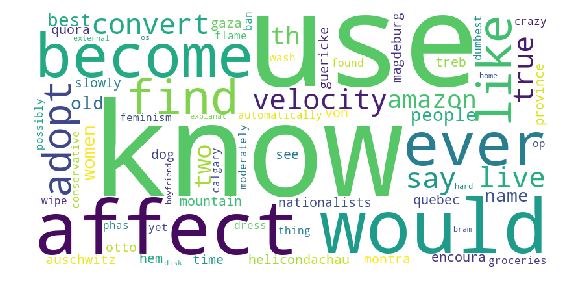

In [11]:
sincere_questions = train_set[train_set.target == 0].qt_clean
insincere_questions = train_set[train_set.target == 1].qt_clean

h.plot_wordcloud(sincere_questions, max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2)
print("Sincere Unigrams")

Insincere Unigrams


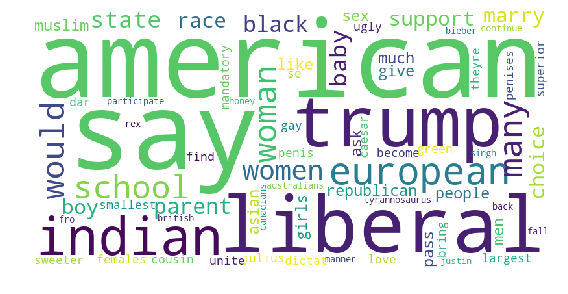

In [12]:
# WordCloud of unigram insincere questions
h.plot_wordcloud(insincere_questions, max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2)
print("Insincere Unigrams")

100%|██████████| 64774/64774 [00:00<00:00, 236729.66it/s]


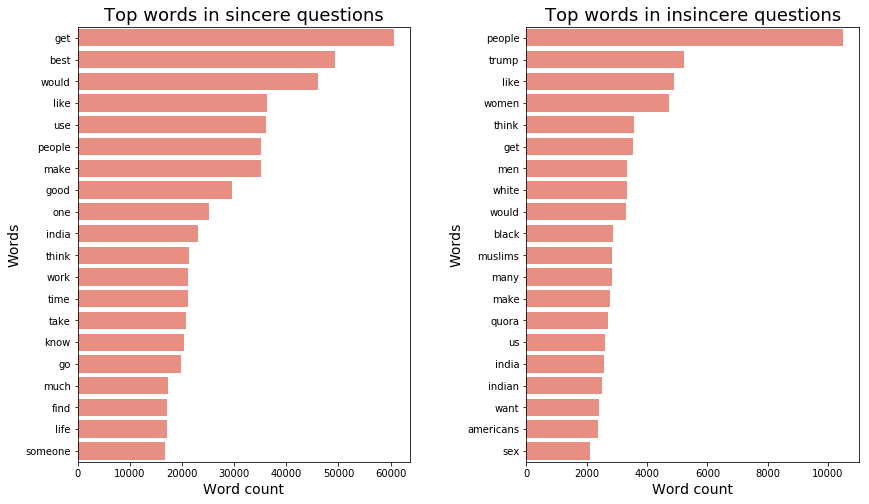

In [29]:
# Word Frequencies by target
wf_sincere = h.word_frequency(train_set.qt_clean_stop[train_set.target==0])
wf_insincere = h.word_frequency(train_set.qt_clean_stop[train_set.target==1])
h.comparison_plot(wf_sincere[:20],wf_insincere[:20],'word','wordcount', .35, figsize = (14,8))

A fast view of the most frequent unigrams show that sincere questions have usual words related to **asking verbs** and overall neutral words. However, insincere unigrams have more **sensitive nouns** like `indian`, `american`, `trump`, etc. 

100%|██████████| 64774/64774 [00:00<00:00, 71403.13it/s]


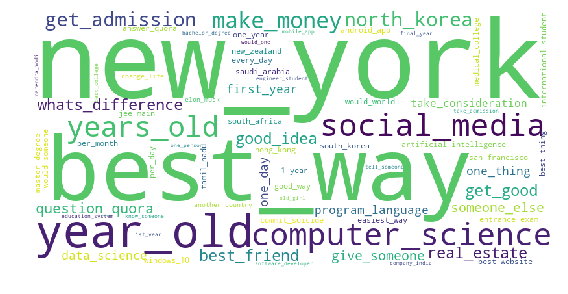

In [19]:
# Bigram Frequencies by target
wf_sincere = h.ngram_frequency(train_set.qt_clean_stop[train_set.target==0], 2)
wf_insincere = h.ngram_frequency(train_set.qt_clean_stop[train_set.target==1], 2)

h.plot_wordcloud(' '.join(wf_sincere.ngram), max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2, collocations = False)

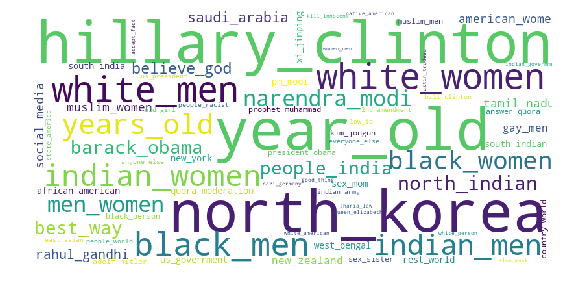

In [20]:
h.plot_wordcloud(' '.join(wf_insincere.ngram), max_words=70, 
max_font_size=100, stop_words = stop_words, 
figure_size=(8,10), scale = 2, collocations = False)

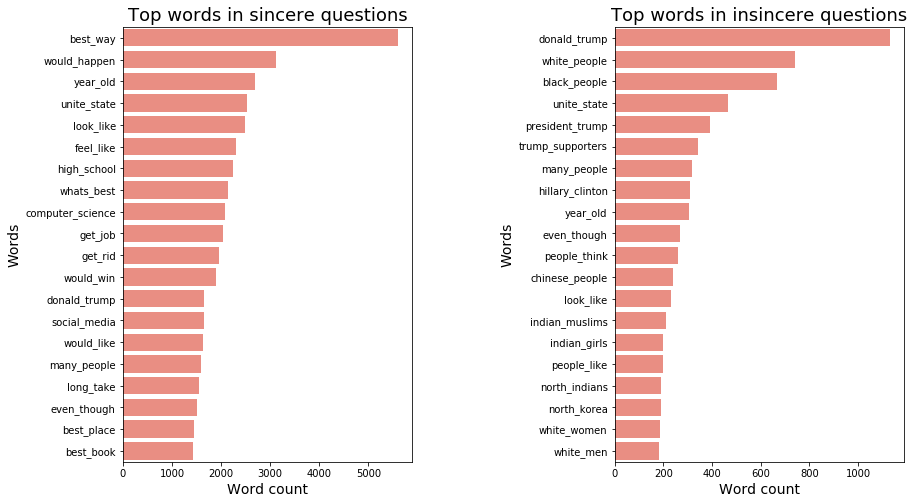

In [28]:
h.comparison_plot(wf_sincere[:20],wf_insincere[:20],'ngram','count', .7, figsize = (14,8))

Bigrams allow us a better understanding of what are the main ideas behind sincere and insincere questions. Its posible to see that many questions are related to find the `best` of place, book, way to do something. On the other hand, insincere questions focus **racial or gender or ethnic** group words. 

### 3.2 Document level Statistics

We will now create basic meta document features to find **outliers**.

In [54]:
with open('Data/train_word_cloud.pkl', 'rb') as input:
    train_set = pickle.load(input)

In [55]:
# Creating several document derived features
train_set['char_count'] = train_set.qt_clean_stop.progress_apply(len) # char clean count
train_set['word_count'] = train_set.qt_clean_stop.progress_apply(lambda x: len(x.split())) # word clean count
train_set['word_density'] = train_set.char_count / (train_set.word_count+1) # word density count

100%|██████████| 1048575/1048575 [00:02<00:00, 517732.19it/s]


In [60]:
col = ['char_count', 'word_count', 'word_density']
train_set[col].describe().applymap(np.int64)
pd.DataFrame(train_set.word_count.value_counts(sort=False).head(10))

,word_count
0,66
1,5723
2,46776
3,129106
4,171437
5,166955
6,133553
7,100260
8,73226
9,53078


There are **66 documents** with zero characters and **5723** with 1 non-stopword word


In [62]:
train_set[train_set.word_count == 0][['question_text', 'target']].head(3)

,question_text,target
29878,How and where are you?,0
40137,"Why, are we all here?",0
50230,What you have in yourself?,0


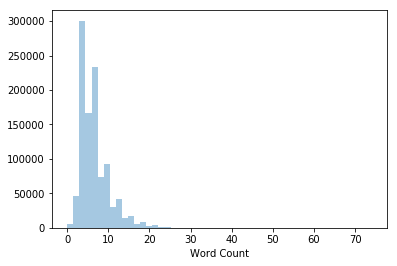

In [66]:
np.percentile(train_set.word_count, [0, 25, 50, 75, 99])
sns.distplot(train_set.word_count, kde=False, axlabel = 'Word Count')

Also its possible to see there are documents with more that **14 words (95% percentile)**.

In [68]:
# Target comparison
train_set[['word_count', 'target']].groupby('target').aggregate([min, np.mean, np.median, max])

word_count                    
              min     mean median max
target                               
0               0 6.311956      5  74
1               0 9.005959      8  40

Text(0.5, 1.0, 'Word Count by Target boxplot')

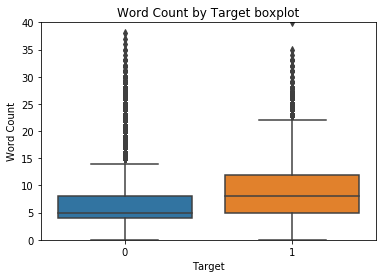

In [69]:
ax = sns.boxplot(x="target", y="word_count", data=train_set[['word_count', 'target']])
ax.set(ylim = [0,40], ylabel = 'Word Count', xlabel = 'Target')
ax.set_title('Word Count by Target boxplot')

It seems that insincere questions tend to be more elaborate than sincere. On average there are **9 words** per insincere questions instead of **6 words** per sincere question. 

**Outlier filtering**
I will eliminate those documents that have lower than **2 "cleaned" words** and over **14 words in length** as seen in the histograms above. 


In [70]:
# Filtering Outlier Documents 
train_set = train_set[(train_set.word_count > 2) & (train_set.word_count < 15)]

### 4. Document Meta features

These following features may aid text feature modelling, and its a necesary step before splitting the data.

In [73]:
with open('Data/train_meta_features.pkl', 'rb') as input:
    train_set = pickle.load(input)
    
col = ['char_count', 'word_count', 'word_density', 'n_stopwords', 
       'n_numbers', 'n_upper', 'polarity', 'subjectivity', 'positivity',
       'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']

# ¿Are they informative of the target? (information gain analysis)
ig_score = mutual_info_classif(train_set[col], train_set.target)
ig_score_df = pd.DataFrame({'metafeatures':col, 
                       'inf_gain':ig_score})
ig_score_df.sort_values('inf_gain', ascending = False)

,metafeatures,inf_gain
11,adj_count,0.051689
13,pron_count,0.049458
10,verb_count,0.046694
12,adv_count,0.041839
9,noun_count,0.032150
1,word_count,0.028448
3,n_stopwords,0.022527
0,char_count,0.010404
6,polarity,0.009371
7,subjectivity,0.007461
